In [8]:
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd

In [9]:
# Download NLTK resources (if you haven't already)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
def clean_email(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Lowercasing
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Stop word removal
    stop_words = set(stopwords.words("english"))
    tokens = [w for w in tokens if not w in stop_words]

    # Stemming (you can also try lemmatization)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

In [11]:
def load_data(spam_dir, ham_dir):
    data = []
    # Load spam emails
    for filename in os.listdir(spam_dir):
        with open(os.path.join(spam_dir, filename), "r", encoding="latin-1") as f:
            text = f.read()
            data.append([clean_email(text), 1])  # 1 for spam

    # Load ham emails
    for filename in os.listdir(ham_dir):
        with open(os.path.join(ham_dir, filename), "r", encoding="latin-1") as f:
            text = f.read()
            data.append([clean_email(text), 0])  # 0 for ham

    return pd.DataFrame(data, columns=["text", "label"])

In [12]:
# Example usage (assuming you have 'spam' and 'ham' directories)
spam_directory = "data/spam"  
ham_directory = "data/ham"

In [13]:
df = load_data(spam_directory, ham_directory)
print(df.head())

C:\Users\muham\AppData\Local\Temp\ipykernel_32512\1684770644.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


                                                text  label
0  subject fw solut mention lsc oo thank email ad...      1
1  subject spend much phone bill crystal clear co...      1
2  subject urgent busi propos mr regina rossman s...      1
3  subject get best rate home loan would like rem...      1
4  subject membership commun charset iso membersh...      1


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [15]:
from sklearn.naive_bayes import MultinomialNB

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.9872
Precision: 0.9967
Recall: 0.9558
F1-score: 0.9758


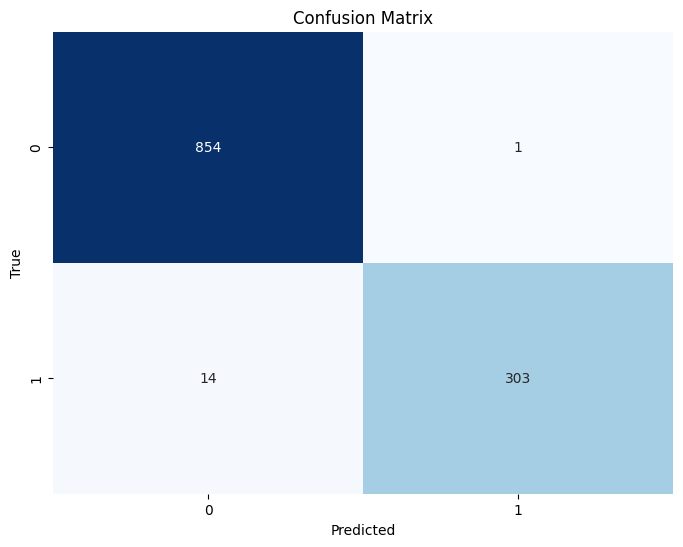

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
def classify_email(email_text, vectorizer, classifier):
    cleaned_text = clean_email(email_text)
    tfidf_vector = vectorizer.transform([cleaned_text])
    prediction = classifier.predict(tfidf_vector)[0]
    return "Spam" if prediction == 1 else "Ham"

# Example usage
new_email = """
Subject: You've won a free iPhone!

Congratulations! You've been selected to win a brand new iPhone 14 Pro Max. 
Click here to claim your prize now: iphoneorgwin
"""

prediction = classify_email(new_email, tfidf_vectorizer, nb_classifier)
print(f"The email is classified as: {prediction}")

The email is classified as: Spam
